# Gas Generator Class Validationa

> Date: 27/04/2025

> Author: Elias Aoubala 

In [1]:
import handcalcs.render
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from turborocket.transient.start_up import GasGenerator
from turborocket.fluids.fluids import IncompressibleFluid

## 1 - Background

This document contains the authors validation of the gas generator class of the turborocket library.
An arbitrary test case was generated, from which a comparison to the regressed results produced from turborocket is made.

## 2 - Test Case #1

This section contains an arbitrary test case setup by the author to demonstrate that the code and adjoint solves are functioning as expected.

### 2.1 - High Level Parameter Definition

**Chamber Conditions**

In [2]:
%%render sci_not param

pcc = 30e5 # Pa
mr_nom = 1
oxidiser = "N2O"
fuel = "Isopropanol"
eta_c = 0.85 
m_dot_t = 100e-3 # kg/s

<IPython.core.display.Latex object>

**Injector Conditions**

In [3]:
%%render sci_not param

p_ox_inlet = 50e5 # Pa
p_fu_inlet = 50e5 # Pa

rho_ox_inlet = 1000 # kg/m**3
rho_fu_inlet = 1000 # kg/m**3

<IPython.core.display.Latex object>

### 2.2 - System Sizing

#### 2.2.1 - Injector Sizing

We can size the injector orifice areas accordingly

In [4]:
%%render

m_dot_f = m_dot_t / (mr_nom + 1)
m_dot_ox = m_dot_t * mr_nom / (mr_nom + 1)

<IPython.core.display.Latex object>

In [5]:
%%render sci_not

cda_fu = m_dot_f / (2 * rho_fu_inlet * (p_fu_inlet - pcc))**(1/2)
cda_ox = m_dot_ox / (2 * rho_ox_inlet * (p_ox_inlet - pcc))**(1/2)

<IPython.core.display.Latex object>

#### 2.2.2 - Combustion Sizing

We can define our `CEA` object, from which we can derive our combustion conditions

In [6]:
# Define CEA Object
cea = CEA_Obj(
    oxName=oxidiser,
    fuelName=fuel,
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

We can now derive our combustion conditions:

In [7]:
%%render param sci_not

T_o = cea.get_Temperatures(Pc=pcc, MR=mr_nom)[0] * eta_c**2
gamma = cea.get_Chamber_MolWt_gamma(Pc=pcc, MR=mr_nom)[1]
cp = cea.get_Chamber_Cp(Pc=pcc, MR=mr_nom)
c_star_a = cea.get_Cstar(Pc=pcc, MR=mr_nom) * eta_c  * 0.3048

Acc = c_star_a * m_dot_t/ pcc

<IPython.core.display.Latex object>

#### 2.2.3 - Defining Throttling Parameters

In this section, we define our key throttling parameters:

In [8]:
%%render sci_not

alpha = mr_nom * ((p_fu_inlet - pcc)/(p_ox_inlet - pcc))**(1/2)

K_f = cda_fu * (2 * rho_fu_inlet)**(1/2)/Acc

<IPython.core.display.Latex object>

#### 2.2.3 - Fuel Throttle Event

We shall now consider the case where the fuel side of the injector is throttled down to 30 bar. 
We will solve for the new combustion conditions accordingly.

In [9]:
%%render sci_not param

p_ox_inlet_2 = 30e5 # Pa
p_fu_inlet_2 = 50e5 # Pa

rho_ox_inlet = 1000 # kg/m**3
rho_fu_inlet = 1000 # kg/m**3

<IPython.core.display.Latex object>

We setup our error equation, and iterate through chamber pressures till we figure out what our new setpoint is.

In [10]:
Pcc_guess = 23.44e5

In [11]:
mr_guess = alpha * ((p_ox_inlet_2 - Pcc_guess)/(p_fu_inlet_2 - Pcc_guess))**(1/2)

lhs = K_f * (
    alpha * (p_ox_inlet_2 - Pcc_guess) ** (1 / 2)
    + (p_fu_inlet_2 - Pcc_guess) ** (1 / 2)
)

print(lhs)

c_star_a = cea.get_Cstar(Pc=pcc, MR=mr_guess) * eta_c * 0.3048

print(f"C_star_a = {c_star_a}")

rhs = Pcc_guess / (c_star_a)

print(rhs)

error = abs(lhs - rhs)/lhs

print(f"Current Error: {error*100} %")

2491.345710387391
C_star_a = 936.532281321396
2502.850191872451
Current Error: 0.4617778029397195 %


We can now extract all our key properties accordingly:

In [12]:
%%render param sci_not

m_dot_ox_2 = cda_ox * (2*rho_ox_inlet * (p_ox_inlet_2 - Pcc_guess))**(1/2) # kg/s
m_dot_f_2 = cda_fu * (2 * rho_fu_inlet * (p_fu_inlet_2 - Pcc_guess)) ** (1 / 2) # kg/s

mr_new = m_dot_ox_2/m_dot_f_2 

# We can now caluate what the new combustion conditions are 
T_o_2 = cea.get_Temperatures(Pc=Pcc_guess, MR=mr_new)[0] * eta_c**2 # K
gamma_2 = cea.get_Chamber_MolWt_gamma(Pc=Pcc_guess, MR=mr_new)[1] 
cp_2 = cea.get_Chamber_Cp(Pc=Pcc_guess, MR=mr_new) # J/ kg K

ox_stiff = (p_ox_inlet_2 - Pcc_guess)/Pcc_guess
fu_stiff = (p_fu_inlet_2 - Pcc_guess)/Pcc_guess

<IPython.core.display.Latex object>

### 2.3 - Turborocket Approach

We intially define our Injector Objects

In [13]:
oxidiser = IncompressibleFluid(rho = rho_ox_inlet, P = p_ox_inlet)
fuel = IncompressibleFluid(rho = rho_fu_inlet, P = p_fu_inlet)

We can now define our gas generator object

In [14]:
GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=pcc, MR=mr_nom)
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)

GG.size_system(m_dot=m_dot_t, eta_c=eta_c)


{'P_cc': 3000000.0,
 'MR': np.float64(1.0),
 'T_o': np.float64(1389.2417281710702),
 'Cp': np.float64(3363.17043825743),
 'gamma': np.float64(0.9937672418596882),
 'ox_stiffness': 0.6666666666666666,
 'fu_stiffness': 0.6666666666666666,
 'm_dot_t': 0.1,
 'm_dot_o': np.float64(0.05),
 'm_dot_f': np.float64(0.05)}

In [ ]:
GG.get_geometry()

{'CdA_ox': np.float64(7.905694150420949e-07),
 'CdA_fu': np.float64(7.905694150420949e-07),
 'A_fu': np.float64(1.3176156917368248e-06),
 'A_ox': np.float64(1.3176156917368248e-06),
 'Acc': 3.462188444199992e-05}

We can now evaluate for our throttling condition

In [16]:
oxidiser_2 = IncompressibleFluid(rho=rho_ox_inlet, P=p_ox_inlet_2)
fuel_2 = IncompressibleFluid(rho=rho_fu_inlet, P=p_fu_inlet_2)

In [17]:
GG.solve_perturb(ox_in=oxidiser_2, fu_in=fuel_2)

{'P_cc': np.float64(2344267.364393084),
 'MR': np.float64(0.4969025485361858),
 'T_o': np.float64(1098.3960706281407),
 'Cp': np.float64(3436.971198183492),
 'gamma': np.float64(0.9888439844383106),
 'ox_stiffness': np.float64(0.27971751241637116),
 'fu_stiffness': np.float64(1.132862520693952),
 'm_dot_t': np.float64(0.08624634699438576),
 'm_dot_o': np.float64(0.028629806038713214),
 'm_dot_f': np.float64(0.05761654095567254)}

## 3 - Appendix A: Comparison of c_star approach vs T_o directly

A comparison is made between the two approaches for getting the gas temperature, namely the direct approach and c_star approach.

In [18]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5,2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star *eta_c

    gamma = cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1))**((gamma + 1)/(-2 * (gamma - 1)))

    R = 8314 / cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma/ (R))*(c_star_a / param)**2) 

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

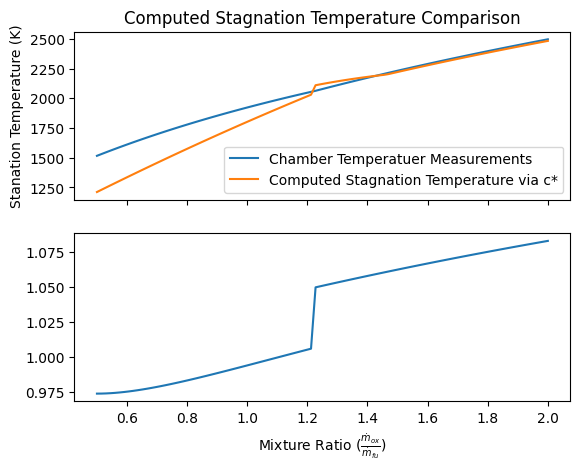

In [19]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr , t_o, label="Chamber Temperatuer Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

As can be seen, at a mixture ratio of about 1.2, the specific heat ratio drops suddenly - resulting in a divergence in the two sets of results.

Let us now consider the case where instead of using chamber combustion conditions, we use the combustion conditions at the throat to figure out what our stagnation temperature is.

In [20]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of)[0]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

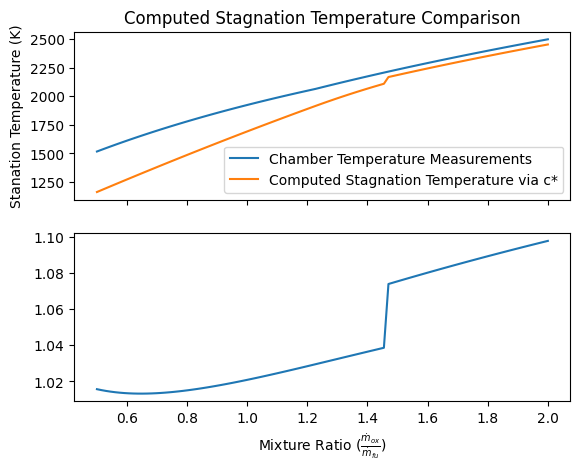

In [21]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr, t_o, label="Chamber Temperature Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

A similar divergence can be seen, howeever this pccurs at a higher O/F.

If we plotted this against the temperature that is local to the throat, we may improve the siutation.

In [22]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of)[1]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

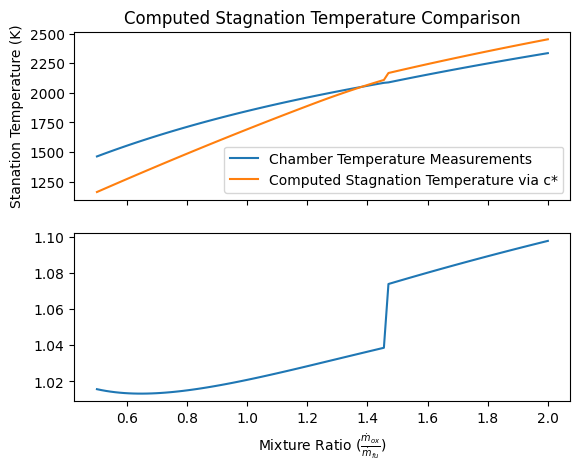

In [23]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr, t_o, label="Chamber Temperature Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

Now let's consider the case where we need to figure out what our stagnation temperature is at the outlet of our engine - lets compare the two approaches we have designed:

In [24]:
eta_c = 0.85
t_a = []
t_o = []

t_ac = []
t_oc = []

gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star / param) ** 2)
    t_ac.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0]))
    t_oc.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0] * eta_c**2))

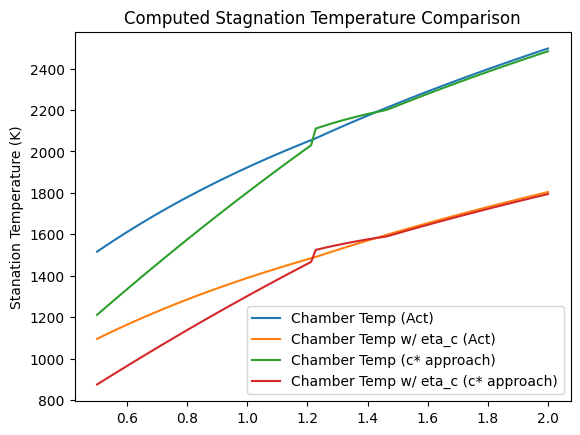

In [25]:
fix, ax = plt.subplots(1, 1, sharex=True)

ax.plot(mr, t_o, label="Chamber Temp (Act)")
ax.plot(mr, t_oc, label="Chamber Temp w/ eta_c (Act)")

ax.plot(mr, t_a, label="Chamber Temp (c* approach)")
ax.plot(mr, t_ac, label="Chamber Temp w/ eta_c (c* approach)")

ax.set_ylabel("Stanation Temperature (K)")
ax.set_title("Computed Stagnation Temperature Comparison")
ax.legend()

In conclusion, the c_star approach will be used for the sizing of the throat and such parameters, however the actual approach will be used for the combustion modelling of the temperatuer.